In [ ]:
from datetime import date, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
data = pd.read_csv("https://compbio.fmph.uniba.sk/vyuka/pridav/data/gisaid-selection.tsv", sep="\t")
data["Collection date"] = pd.to_datetime(data["Collection date"])
data["Submission date"] = pd.to_datetime(data["Submission date"])
data


Virus name Last vaccinated  \
0      hCoV-19/Czech_Republic/FNHK-Ps-001606/2021             NaN   
1                hCoV-19/Denmark/DCGC-276339/2021             NaN   
2                hCoV-19/Denmark/DCGC-276856/2021             NaN   
3                hCoV-19/Denmark/DCGC-213960/2021             NaN   
4                hCoV-19/Denmark/DCGC-214000/2021             NaN   
...                                           ...             ...   
23062            hCoV-19/Denmark/DCGC-290826/2021             NaN   
23063            hCoV-19/Denmark/DCGC-281777/2021             NaN   
23064            hCoV-19/Denmark/DCGC-285112/2021             NaN   
23065      hCoV-19/Czech_Republic/20SVAN9209/2022             NaN   
23066            hCoV-19/Denmark/DCGC-278515/2021             NaN   

      Passage details/history             Type     Accession ID  \
0                    Original  betacoronavirus  EPI_ISL_8207439   
1                    Original  betacoronavirus  EPI_ISL_7914541   
2                    Original  betacoronavirus  EPI_ISL_7915541   
3                    Original  betacoronavirus  EPI_ISL_6437989   
4                    Original  betacoronavirus  EPI_ISL_6438031   
...                       ...              ...              ...   
23062                Original  betacoronavirus  EPI_ISL_8344382   
23063                Original  betacoronavirus  EPI_ISL_8002809   
23064                Original  betacoronavirus  EPI_ISL_8135539   
23065                Original  betacoronavirus  EPI_ISL_9627242   
23066                Original  betacoronavirus  EPI_ISL_7917949   

      Collection date                                           Location  \
0          2021-12-08         Europe / Czech Republic / Pardubice Region   
1          2021-12-07                     Europe / Denmark / Hovedstaden   
2          2021-12-06                     Europe / Denmark / Hovedstaden   
3          2021-11-10                     Europe / Denmark / Midtjylland   
4          2021-11-10                       Europe / Denmark / Sjaelland   
...               ...                                                ...   
23062      2021-12-17                     Europe / Denmark / Hovedstaden   
23063      2021-12-09                     Europe / Denmark / Hovedstaden   
23064      2021-12-19                     Europe / Denmark / Nordjylland   
23065      2022-01-20  Europe / Czech Republic / Moravian-Silesian Re...   
23066      2021-12-07                     Europe / Denmark / Midtjylland   

      Additional location information  Sequence length   Host  ...  \
0                     Zip code: 53003            29703  Human  ...   
1                                 NaN            29769  Human  ...   
2                                 NaN            29769  Human  ...   
3                                 NaN            29848  Human  ...   
4                                 NaN            29769  Human  ...   
...                               ...              ...    ...  ...   
23062                             NaN            29769  Human  ...   
23063                             NaN            29769  Human  ...   
23064                             NaN            29769  Human  ...   
23065                 Zip code: 73301            29881  Human  ...   
23066                             NaN            29769  Human  ...   

      Pangolin version                                            Variant  \
0       PLEARN-v1.15.1  VOC Delta GK (B.1.617.2+AY.*) first detected i...   
1       PLEARN-v1.15.1  VOC Delta GK (B.1.617.2+AY.*) first detected i...   
2       PLEARN-v1.15.1  VOC Delta GK (B.1.617.2+AY.*) first detected i...   
3        PANGO-v1.15.1  VOC Delta GK (B.1.617.2+AY.*) first detected i...   
4       PLEARN-v1.15.1  VOC Delta GK (B.1.617.2+AY.*) first detected i...   
...                ...                                                ...   
23062   PLEARN-v1.15.1  VOC Delta GK (B.1.617.2+AY.*) first detected i...   
23063    PANGO-v1.15.1  VOC Delta G

In [ ]:
def select_data(country,start_date = '2021-11-01', end_date = '2022-03-31'):
  all_dates = pd.date_range(start=start_date, end=end_date)
  n = all_dates.size
  result = pd.DataFrame({ 'date': all_dates, 'omicron': [0] * n, 'ba2': [0] * n, 'other': [0] * n})

  for i in range(len(data)):
    loc = data["Location"][i]
    coldate = data["Collection date"][i]
    var = data["Variant"][i]
    pango = data["Pango lineage"][i]

    if country in loc and coldate >= pd.to_datetime(start_date) and coldate <= pd.to_datetime(end_date):
      d = (coldate-pd.to_datetime(start_date)).days
      # classify which variant
      variant = 'other'
      if pd.notna(var) and 'Omicron' in var:
        if pd.notna(pango) and 'BA.2' in pango:
          variant = 'ba2'
        else:
          variant = 'omicron'
      result.loc[d,variant] += 1

  result['all'] = result['omicron'] + result['ba2'] + result['other']

  return result;



In [ ]:
#res = select_data("Denmark")
res = select_data("Slovak")
#res = select_data("Czech")

display(res[:][70:80])



date  omicron  ba2  other  all
70 2022-01-10        7    1      3   11
71 2022-01-11        3    0      2    5
72 2022-01-12        5    0      0    5
73 2022-01-13        4    0      0    4
74 2022-01-14        1    0      1    2
75 2022-01-15        2    0      0    2
76 2022-01-16        3    0      0    3
77 2022-01-17        6    0      2    8
78 2022-01-18        4    0      0    4
79 2022-01-19        2    0      2    4

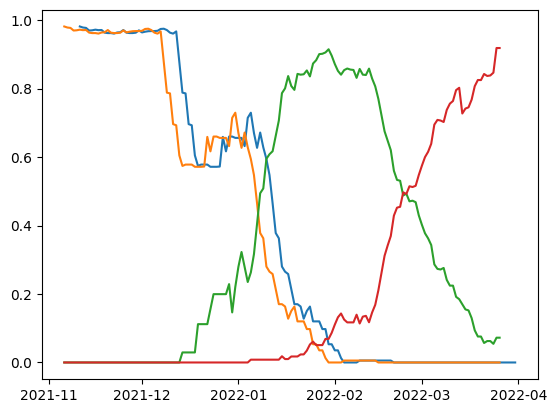

In [ ]:
window = 11
eps = 0.1
mp = window
othernc = (res['other'] / (res['all'] + eps)).rolling(window, center=False, min_periods=mp).mean()
other = (res['other'] / (res['all'] + eps)).rolling(window, center=True, min_periods=mp).mean()
omicron = (res['omicron'] / (res['all'] + eps)).rolling(window, center=True, min_periods=mp).mean()
ba2 = (res['ba2'] / (res['all'] + eps)).rolling(window, center=True, min_periods=mp).mean()
plt.plot(res['date'],othernc)
plt.plot(res['date'],other)
plt.plot(res['date'],omicron)
plt.plot(res['date'],ba2)

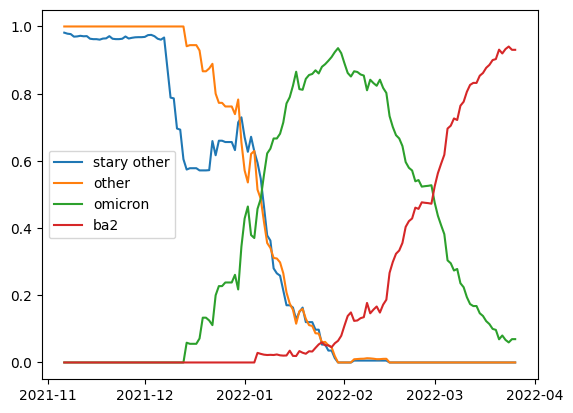

In [ ]:
def mojrolling(x,all):
  xroll = x.rolling(window, center=True, min_periods=mp).sum()
  allroll = all.rolling(window, center=True, min_periods=mp).sum()
  return xroll / allroll

plt.plot(res['date'],other,label = 'stary other')
plt.plot(res['date'],mojrolling(res['other'],res['all']), label = 'other')
plt.plot(res['date'],mojrolling(res['omicron'],res['all']), label = 'omicron')
plt.plot(res['date'],mojrolling(res['ba2'],res['all']), label = 'ba2')
plt.legend()

In [ ]:
## see https://towardsdatascience.com/locally-weighted-linear-regression-in-python-3d324108efbf

# Weight Matrix in code. It is a diagonal matrix.
def wm(point, X, w, tau):

  # tau --> bandwidth
  # X --> Training data.
  # point --> the x where we want to make the prediction.

  # m is the No of training examples .
    m = X.shape[0]

  # Initialising W as an identity matrix.
    ww = np.eye(m)

  # Calculating weights for all training examples [x(i)'s].
    for i in range(m):
        xi = X[i]
        d = (-2 * tau * tau)
        ww[i, i] = w[i]*np.exp(np.dot((xi-point), (xi-point).T)/d)

    return ww


def predict(X, y, w, point, tau):

   # m = number of training examples.
    m = X.shape[0]

   # point is the x where we want to make the prediction.
    point_ = np.array([point, 1])

   # Calculating the weight matrix using the wm function we wrote
   # earlier.
    ww = wm(point_, X, w, tau)

  # Calculating parameter theta using the formula.
  #  theta = np.linalg.pinv(X.T*(ww * X))*(X.T*(ww * y))
    theta = np.linalg.pinv(X.T@(ww@X))@(X.T@(ww@y))
  # Calculating predictions.
    pred = np.dot(point_, theta)

   # Returning the theta and predictions
    return pred

def mojlowess(x,all,tau):
  xx = []
  yy = []
  ww = []
  n = 0

  for i in range(x.size):
    if (all[i]>0):
      xx.extend([i,i])
      yy.extend([0.0,1.0])
      ww.extend([all[i]-x[i],x[i]])
      n += 1

  xx = np.array(xx)
  yy = np.array(yy)
  ww = np.array(ww)
  X = np.append(xx.reshape(2*n,1),np.ones(2*n).reshape(2*n,1),axis=1)

  pred = []
  for i in range(x.size):
    pred.append(predict(X,yy,ww,i,tau))

  return pred

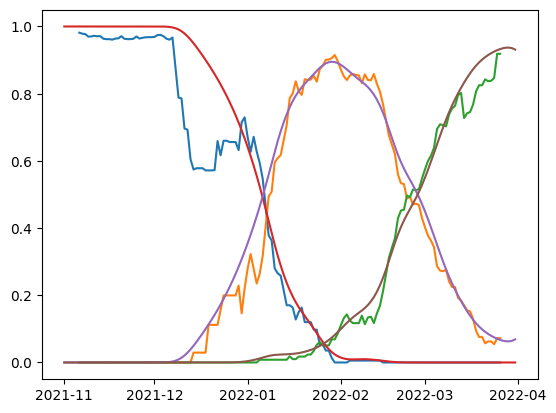

In [ ]:
smoothfactor = 5
lwother = mojlowess(res['other'],res['all'],smoothfactor)
lwba2 = mojlowess(res['ba2'],res['all'],smoothfactor)
lwomi = mojlowess(res['omicron'],res['all'],smoothfactor)

plt.plot(res['date'],other)
plt.plot(res['date'],omicron)
plt.plot(res['date'],ba2)
plt.plot(res['date'],lwother)
plt.plot(res['date'],lwomi)
plt.plot(res['date'],lwba2)